## KNN Model

In [8]:
import re
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class KNNModel:
    def __init__(self):
        self.best_knn = None
        self.grid_search = None

        
    def fit(self, X_train, y_train, param_grid):
        knn = KNeighborsClassifier()
        self.grid_search = GridSearchCV(knn, param_grid, cv=5)
        self.grid_search.fit(X_train, y_train)
        self.best_knn = self.grid_search.best_estimator_
        
        k_values = None
        k_parameter_pattern = re.compile(r'n[_]?neighbors|k[_]?values', re.IGNORECASE)
        for key, value in param_grid.items():
            if isinstance(value, list) and k_parameter_pattern.search(key):
                k_values = value
                break
        
        if k_values is None:
            raise ValueError("K-values not found in param_grid")
        
        # compute the accuracy score for each hyperparameter combination
        cv_results = self.grid_search.cv_results_
        test_scores_mean = cv_results['mean_test_score']
        test_scores_stds = cv_results['std_test_score']
        for mean, std, params in zip(test_scores_mean, test_scores_stds, cv_results['params']):
            print(f"Accuracy: {mean:.3f} (±{std*2:.3f}) for {params}")

        # Display average accuracy for each hyperparameter combination
        results_df = pd.DataFrame(cv_results)
        results_df_sorted = results_df.sort_values(by='mean_test_score', ascending=False)
        param_cols = ['param_' + key for key in param_grid.keys()]
        mean_test_score_col = 'mean_test_score'
        print(results_df_sorted[param_cols + [mean_test_score_col]])

        # print the best hyperparameters
        best_params = self.grid_search.best_params_
        print("Best Hyperparameters:", best_params)

        plt.figure(figsize=(10, 8))
        plt.plot(k_values, 1 - test_scores_mean, label='Training Error')
        plt.xlabel('k')
        plt.ylabel('Error Rate')
        plt.title('Error Rates for k-nearest neighbors')
        plt.legend()
        plt.grid(True)
        plt.show()

        min_cv_k = np.argmin(1-test_scores_mean)
        print(f"The number of nearest neighbors (k) associated with the smallest training error is {k_values[min_cv_k]}")
          # Print training accuracy
        train_accuracy = self.best_knn.score(X_train, y_train)
        print(f"Training Accuracy: {train_accuracy}")

        
    def evaluate(self, X_test, y_test):
        if self.best_knn is None:
            raise ValueError("Fit the model before evaluating")
        
        test_accuracy = self.best_knn.score(X_test, y_test)
        print(f"Test Accuracy: {test_accuracy}")
        
        knn_predictions = self.best_knn.predict(X_test)
        
        print("KNN Classification Report:")
        print(classification_report(y_test, knn_predictions))
        
        # Plot confusion matrix
        conf_matrix = confusion_matrix(y_test, knn_predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('KNN Confusion Matrix')
        plt.show()

        #probability estimates for positive class
        y_probs = self.best_knn.predict_proba(X_test)
        # Compute ROC curve and ROC area for each class
        n_classes = len(self.best_knn.classes_)
        plt.figure(figsize=(8, 8))
        if n_classes > 2:
            for i in range(n_classes):
                fpr, tpr, thresholds = roc_curve(y_test == i, y_probs[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, lw=2, label=f'ROC curve (Class {i} vs the rest) (AUC = {roc_auc:.2f})')
        else:
            fpr, tpr, thresholds = roc_curve(y_test, y_probs[:, 1])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()
        
        
    def kfold_cv(self, X_train, y_train, X_test, y_test, k_values):
        training_errors = []
        cv_errors_list = []
        avg_cv_errors = []
        test_errors = []

        for k in k_values:
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train, y_train)

            training_error = 1 - knn.score(X_train, y_train)
            cv_errors = cross_val_score(knn, X_train, y_train, cv=10)
            avg_cv_error = 1 - np.mean(cv_errors)
            test_error = 1 - knn.score(X_test, y_test)

            training_errors.append(training_error)
            test_errors.append(test_error)
            avg_cv_errors.append(avg_cv_error)
            cv_errors_list.append(cv_errors)

        plt.figure(figsize=(10, 8))
        plt.plot(k_values, training_errors, label='Training Error')
        plt.plot(k_values, test_errors, label='Test Error')
        plt.plot(k_values, avg_cv_errors, label='CV Error')
        #plt.errorbar(k_values, avg_cv_errors, yerr=np.std(avg_cv_errors), label='CV Error', c='green', marker='o', capsize=5)
        #plt.errorbar(k_values, avg_cv_errors, yerr=[np.std(errors) for errors in cv_errors_list], label='CV Error', c='green', marker='o', capsize=5)
        
        plt.xlabel('k')
        plt.ylabel('Error Rate')
        plt.title('Error Rates for k-nearest neighbors')
        plt.legend()
        plt.grid(True)
        plt.show()

        min_cv_k = np.argmin(avg_cv_errors)
        min_test_k = np.argmin(test_errors)
        print(f"The number of nearest neighbors (k) with the smallest cross-validation error is {k_values[min_cv_k]} and an error of {avg_cv_errors[min_cv_k]}")
        print(f"The number of nearest neighbors (k) with the smallest test error is {k_values[min_test_k]} and an error of {test_errors[min_test_k]}")
        
    def bootstrap(self, X_train, y_train, n_bootstrap, k_folds=5):
        
        bootstrap_accuracy_list = []
        for b in range(n_bootstrap):
            resampled_X_train, resampled_y_train = resample(X_train, y_train, replace=True, random_state=b)
            kf = KFold(n_splits=k_folds, shuffle=True, random_state=b)

            fold_accuracy_list = []
            for train_index, val_index in kf.split(resampled_X_train):
                X_train_fold, X_val_fold = resampled_X_train[train_index], resampled_X_train[val_index]
                y_train_fold, y_val_fold = resampled_y_train[train_index], resampled_y_train[val_index]

                self.best_knn.fit(X_train_fold, y_train_fold)
                fold_accuracy = self.best_knn.score(X_val_fold, y_val_fold)
                fold_accuracy_list.append(fold_accuracy)

            bootstrap_accuracy = np.mean(fold_accuracy_list)
            bootstrap_accuracy_list.append(bootstrap_accuracy)

        # Calculate the 5th and 95th percentiles
        mean_acc = np.mean(bootstrap_accuracy_list)
        percentile_5 = np.percentile(bootstrap_accuracy_list, 5)
        percentile_95 = np.percentile(bootstrap_accuracy_list, 95)
        print("Mean accuracy: ", mean_acc)
        print(f"5th percentile of accuracy: {percentile_5}")
        print(f"95th percentile of accuracy: {percentile_95}")


## Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from ucimlrepo import fetch_ucirepo 

#%% load Wisconsin Breast Cancer dataset using ucimlrepo
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets

#print(X.dtypes)
#print(y.dtypes)
print(X.shape)
print(y.shape)

(569, 30)
(569, 1)


In [3]:
#%% analyse features
target = y['Diagnosis']
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=M, Count=212, Percentage=37.258%
Class=B, Count=357, Percentage=62.742%


In [4]:
from sklearn.preprocessing import LabelEncoder
X = X.to_numpy()
# Assuming y_train contains the target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y['Diagnosis'])
print(label_encoder.classes_)

['B' 'M']


In [5]:
#%% split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.1, random_state=42)


## PCA

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dimensionality Reduction using PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Get the number of components that explain 95% of variance
original_components = X_train_scaled.shape[1]
p_components = pca.n_components_
print(f"Total Number of components: {original_components}")
print(f"Number of components explaining 95% variance: {p_components}")



Total Number of components: 30
Number of components explaining 95% variance: 10


## Base KNN with scaled data

Accuracy: 0.941 (±0.033) for {'n_neighbors': 1}
Accuracy: 0.949 (±0.034) for {'n_neighbors': 2}
Accuracy: 0.963 (±0.049) for {'n_neighbors': 3}
Accuracy: 0.959 (±0.050) for {'n_neighbors': 4}
Accuracy: 0.963 (±0.044) for {'n_neighbors': 5}
Accuracy: 0.965 (±0.047) for {'n_neighbors': 6}
Accuracy: 0.965 (±0.036) for {'n_neighbors': 7}
Accuracy: 0.961 (±0.045) for {'n_neighbors': 8}
Accuracy: 0.965 (±0.047) for {'n_neighbors': 9}
Accuracy: 0.959 (±0.034) for {'n_neighbors': 10}
Accuracy: 0.961 (±0.033) for {'n_neighbors': 11}
Accuracy: 0.957 (±0.032) for {'n_neighbors': 12}
Accuracy: 0.959 (±0.031) for {'n_neighbors': 13}
Accuracy: 0.957 (±0.032) for {'n_neighbors': 14}
Accuracy: 0.959 (±0.031) for {'n_neighbors': 15}
Accuracy: 0.955 (±0.032) for {'n_neighbors': 16}
Accuracy: 0.957 (±0.032) for {'n_neighbors': 17}
Accuracy: 0.953 (±0.034) for {'n_neighbors': 18}
Accuracy: 0.957 (±0.032) for {'n_neighbors': 19}
Accuracy: 0.955 (±0.034) for {'n_neighbors': 20}
Accuracy: 0.957 (±0.032) for 

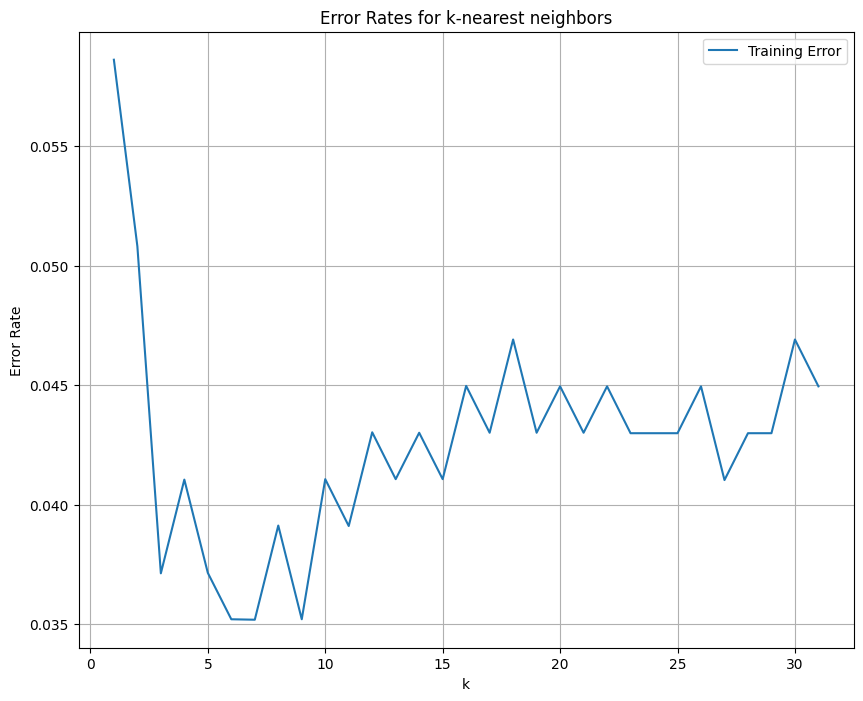

The number of nearest neighbors (k) associated with the smallest training error is 7
Training Accuracy: 0.974609375


In [9]:
#Base KNN model
knn_model = KNNModel()
param_grid = {'n_neighbors': list(range(1, 32))}
#param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
knn_model.fit(X_train_scaled, y_train, param_grid)

Test Accuracy: 0.9298245614035088
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        40
           1       0.88      0.88      0.88        17

    accuracy                           0.93        57
   macro avg       0.92      0.92      0.92        57
weighted avg       0.93      0.93      0.93        57



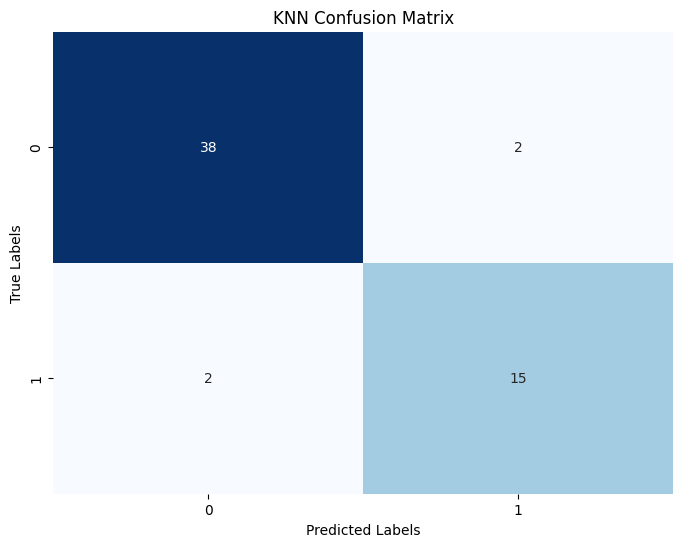

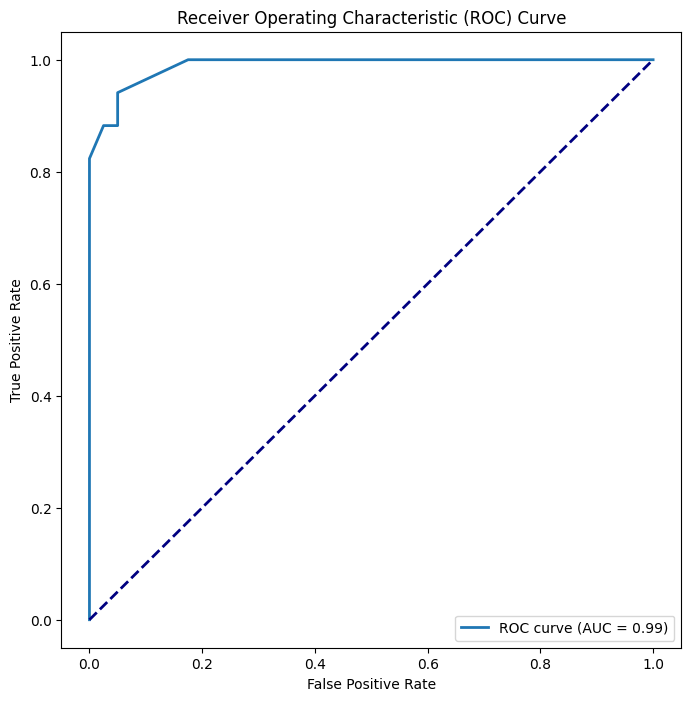

In [10]:
knn_model.evaluate(X_test_scaled, y_test)

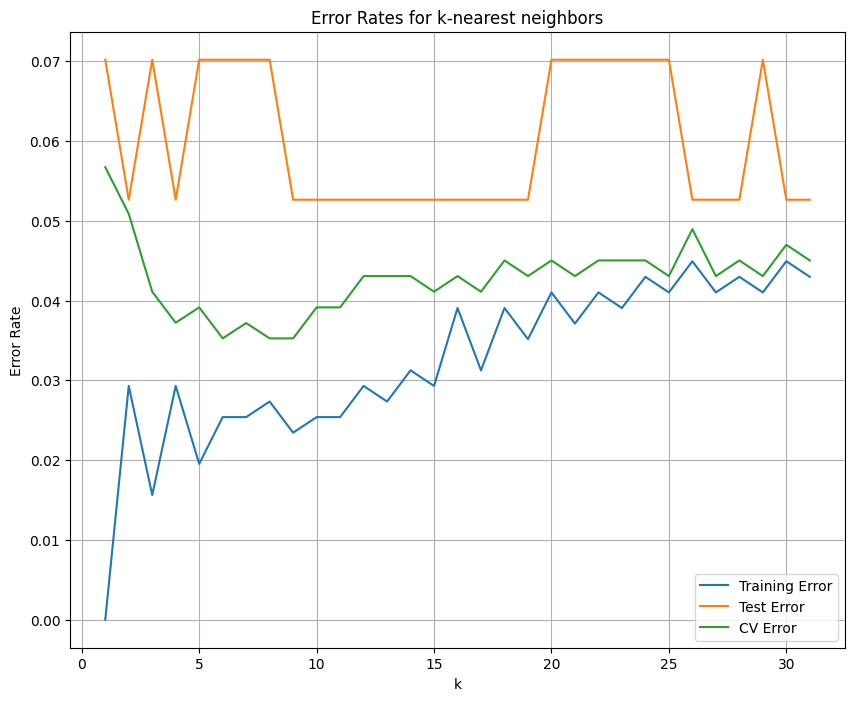

The number of nearest neighbors (k) with the smallest cross-validation error is 6 and an error of 0.03525641025641024
The number of nearest neighbors (k) with the smallest test error is 2 and an error of 0.052631578947368474


In [11]:
#KFold cross validation KNN
param_grid = {'n_neighbors': list(range(1, 32))}
#param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
knn_model.kfold_cv(X_train_scaled, y_train, X_test_scaled, y_test, param_grid['n_neighbors'])

## Bootstrap resampling with base KNN

In [11]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample

n_bootstrap = 300
knn_model.bootstrap(X_train_scaled, y_train, n_bootstrap)





Mean accuracy:  0.9650494955263658
5th percentile of accuracy: 0.9531125071387778
95th percentile of accuracy: 0.978489434608795


## KNN + PCA

Accuracy: 0.963 (±0.014) for {'n_neighbors': 1}
Accuracy: 0.951 (±0.028) for {'n_neighbors': 2}
Accuracy: 0.957 (±0.036) for {'n_neighbors': 3}
Accuracy: 0.961 (±0.048) for {'n_neighbors': 4}
Accuracy: 0.965 (±0.040) for {'n_neighbors': 5}
Accuracy: 0.963 (±0.038) for {'n_neighbors': 6}
Accuracy: 0.963 (±0.036) for {'n_neighbors': 7}
Accuracy: 0.963 (±0.045) for {'n_neighbors': 8}
Accuracy: 0.959 (±0.040) for {'n_neighbors': 9}
Accuracy: 0.957 (±0.034) for {'n_neighbors': 10}
Accuracy: 0.961 (±0.033) for {'n_neighbors': 11}
Accuracy: 0.959 (±0.034) for {'n_neighbors': 12}
Accuracy: 0.963 (±0.034) for {'n_neighbors': 13}
Accuracy: 0.959 (±0.034) for {'n_neighbors': 14}
Accuracy: 0.959 (±0.034) for {'n_neighbors': 15}
Accuracy: 0.955 (±0.034) for {'n_neighbors': 16}
Accuracy: 0.963 (±0.023) for {'n_neighbors': 17}
Accuracy: 0.951 (±0.037) for {'n_neighbors': 18}
Accuracy: 0.949 (±0.038) for {'n_neighbors': 19}
Accuracy: 0.951 (±0.037) for {'n_neighbors': 20}
Accuracy: 0.953 (±0.034) for 

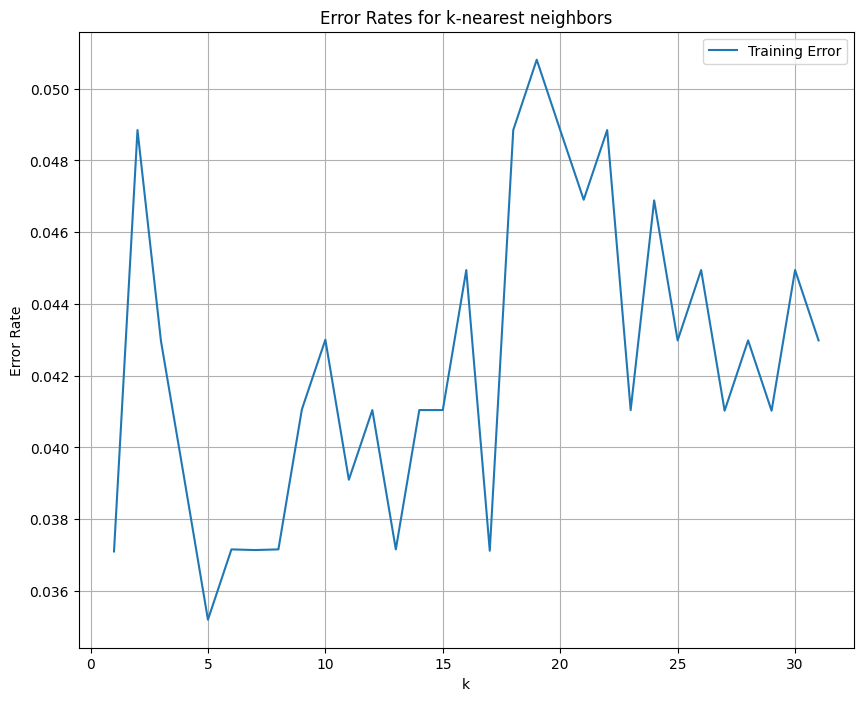

The number of nearest neighbors (k) associated with the smallest training error is 5
Training Accuracy: 0.978515625


In [12]:
#Base KNN model
knn_pca_model = KNNModel()
param_grid = {'n_neighbors': list(range(1, 32))}
#param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
knn_pca_model.fit(X_train_pca, y_train, param_grid)

Test Accuracy: 0.9298245614035088
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        40
           1       0.88      0.88      0.88        17

    accuracy                           0.93        57
   macro avg       0.92      0.92      0.92        57
weighted avg       0.93      0.93      0.93        57



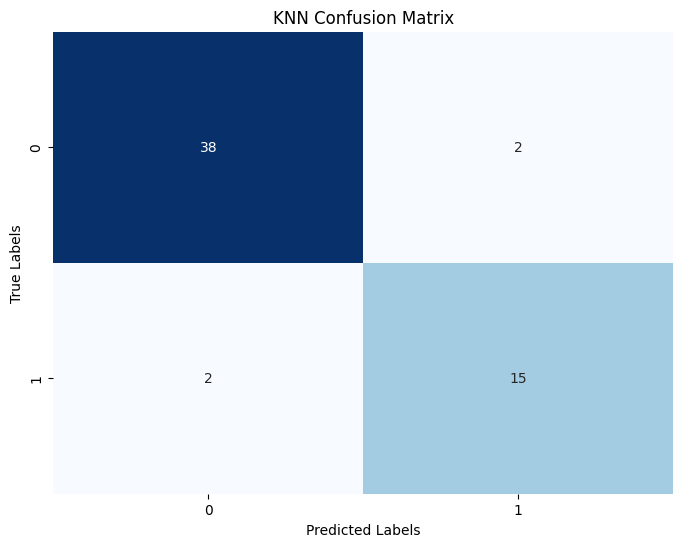

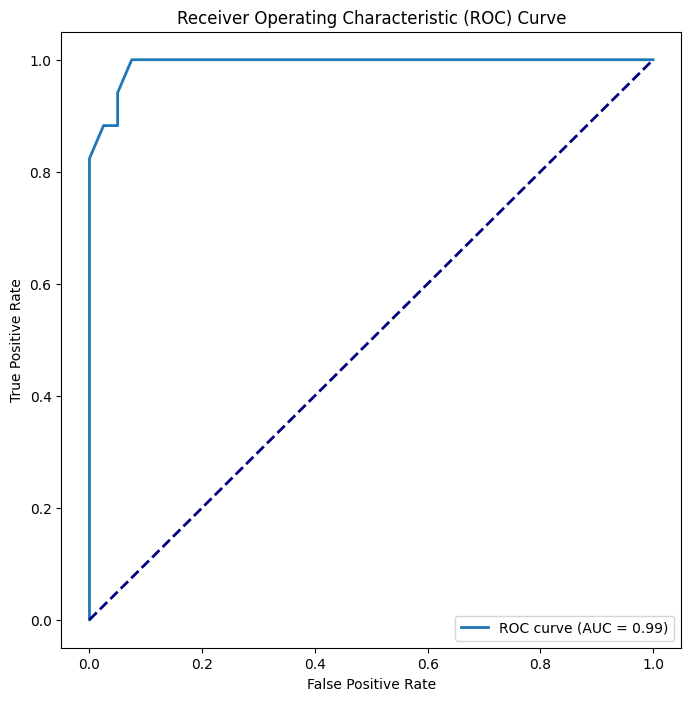

In [13]:
knn_pca_model.evaluate(X_test_pca, y_test)

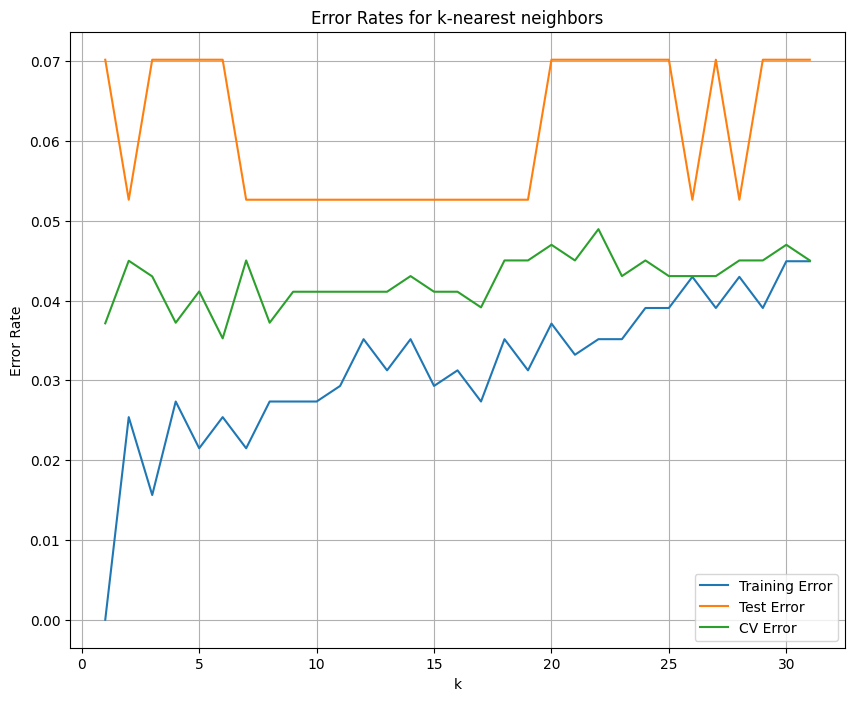

The number of nearest neighbors (k) with the smallest cross-validation error is 6 and an error of 0.03525641025641024
The number of nearest neighbors (k) with the smallest test error is 2 and an error of 0.052631578947368474


In [14]:
#KFold cross validation KNN
param_grid = {'n_neighbors': list(range(1, 32))}
#param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
knn_pca_model.kfold_cv(X_train_pca, y_train, X_test_pca, y_test, param_grid['n_neighbors'])

In [96]:
n_bootstrap = 300
knn_pca_model.bootstrap(X_train_pca, y_train, n_bootstrap)

Mean accuracy:  0.9671343359350213
5th percentile of accuracy: 0.9531496287835522
95th percentile of accuracy: 0.9804302303445651
